# Deep Convolutional Generative Adversarial Networks with TensorFlow

### How to build and train a DCGAN to generate images of faces, using a Jupyter Notebook and TensorFlow.

## By Dominic Monn November 2, 2017

O'Reilley Article: https://www.oreilly.com/ideas/deep-convolutional-generative-adversarial-networks-with-tensorflow

GitHub code repo: https://github.com/dmonn/dcgan-oreilly

In this tutorial, we will try to build a GAN that is able to generate human faces with TensorFlow. Sounds scary, doesn’t it?
 

> *** Note ***: This derived Jupyter Notebook «DCGANs_with_Tensorflow_extended.ipynb» is a small contribution <br/>by Claude COULOMBE, PhD candidate, TÉLUQ / UQAM - Montréal.



 ## Introduction
 
 The concept of generative adversarial networks (GANs) was introduced less than four years ago by Ian Goodfellow. Goodfellow uses the metaphor of an art critic and an artist to describe the two models—discriminators and generators—that make up GANs. An art critic (the discriminator) looks at an image and tries to determine if its real or a forgery. An artist (the generator) who wants to fool the art critic tries to make a forged image that looks as realistic as possible. These two models “battle” each other; the discriminator uses the output of the generator as training data, and the generator gets feedback from the discriminator. Each model becomes stronger in the process. In this way, GANs are able to generate new complex data, based on some amount of known input data, in this case, images.

It may sound scary to implement GANs, but it doesn’t have to be. In this tutorial, we will use TensorFlow to build a GAN that is able to generate images of human faces.

## Architecture of our DCGAN

In this tutorial, we are not trying to mimic simple numerical data — we are trying to mimic an image, which should even be able to fool a human. The generator takes a randomly generated noise vector as input data and then uses a technique called deconvolution to transform the data into an image.

The discriminator is a classical convolutional neural network, which classifies real and fake images.

<img src="https://d3ansictanv2wj.cloudfront.net/basic_gan-7319eab235d83fe971fb769f62cbb15d.png"/>
<!--<img src="images/basic_gan.png" width=800 />-->

<center>Figure 1. Simplified visualization of a GAN. Image source: <a href="https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners">“Generative Adversarial Networks for Beginners”</a>, O’Reilly.</center>


We are going to use the original DCGAN architecture from the paper <a href="https://goo.gl/1HkBQ4">Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks</a>, which consists of four convolutional layers for the discriminator and four deconvolutional layers for the generator.

The companion scientific paper (abstract) https://goo.gl/1HkBQ4, (full PDF): https://goo.gl/t3d36z

## Setup

Please access the <a href="https://github.com/dmonn/dcgan-oreilly">code and Jupyter Notebook for this tutorial on GitHub</a>. All instructions are in the README file in the GitHub repository. A helper function will automatically download the CelebA data set to get you up and running quickly. Be sure to have matplotlib installed to actually see the images and requests to download the data set. If you don’t want to install it yourself, there is a Docker image included in the repository.

Used Libraries:
* matplotlib
* PIL / Pillow
* numpy
* requests
* tqdm
* TensorFlow

## The CelebA data set

The CelebFaces Attributes data set contains more than 200,000 celebrity images, each with 40 attribute annotations. Since we just want to generate images of random faces, we are going to ignore the annotations. The data set includes more than 10,000 different identities, which is perfect for our cause.

<img src="https://d3ansictanv2wj.cloudfront.net/celeb_a_data_set-c07e541876b207cb730d5997fa418dfa.jpg"/>
<!--<img src="images/celeb_a_data_set.jpg" width=300 />-->
<center>Figure 2. Some examples of the CelebA data set. Image courtesy of Dominic Monn.</center>

At this point, we are also going to define to function for batch generation. This function will load our images and give us an array of images according to a batch size we are going to set later. 

A helper function will automatically download the CelebA dataset to get you up and running quickly. Be sure to have matplotlib installed to actually see the images. The download is 1.7GB large, so be sure to have enough disk space and a stable internet connection ready.

In [30]:
import helper

data_dir = './data'
# Let's download the dataset
helper.download_celeb_a()

Found Celeb-A - skip


### Data Pre-Processing

To get some better results, we will crop the images, so that only the faces are showing. We will also normalize the images so that their values are in a range from -0,5 to +0,5. At last, we are going to downscale the images to 28x28 after that.

At this point, we are also going to define a function for batch generation. This function will load our images and give us an array of images according to a batch size we are going to set later. To get better results, we will crop the images, so that only the faces are showing. We will also normalize the images so that their pixel values are in a range from -0.5 to +0.5. Last, we are going to downscale the images to 28x28 after that. This makes us lose some image quality, but it decreases the training time dramatically.

Image normalization done!


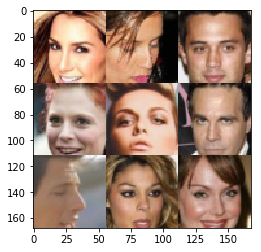

In [15]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np

# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
# data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))
data_files = glob(os.path.join(data_dir, 'celebA/*.png'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255
    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])
        current_index += batch_size
        yield data_batch / IMAGE_MAX_VALUE - 0.5
        
# test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.png'))[:10], 56, 56)
pyplot.imshow(helper.images_square_grid(test_images))

print("Image normalization done!")

## Defining network input

Before we can start defining our two networks, we are going to define our inputs. We are doing this to not clutter the training function any more than it already is. Here, we are simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

```Python
def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real=tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real') 
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real,inputs_z,learning_rate
```

TensorFlow makes it particularly easy to assign variables to placeholders. After we’ve done this, we can use the placeholders in our network by specifying a feed dictionary later.

In [16]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real=tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real') 
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate=tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate

print("Model inputs created")

Model inputs created


## The discriminator network

Finally, we are coming to the first of the dueling networks. The discriminator is the “art critic”, who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification. Simply said, this is a convolutional neural network for image classification. If you already have some experience with deep learning, chances are you have already built a network very similar to this one.

The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

<img src="https://d3ansictanv2wj.cloudfront.net/page4-515a902921add733ec6550b643b7e4d4.png"/>

<!--<img src="images/discriminator.png" width=700 />-->
<center>Figure 3. The discriminator performs multiple convolutions.Source: O'Reilly, based on figures from <br/><a href="https://arxiv.org/abs/1511.06434">"Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks."</a>
</center>

We are going to use a TensorFlow variable scope when defining this network. This helps us in the training process later so we can reuse our variable names for both the discriminator and the generator.

```Python
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # … the model
```

Our discriminator network consists of three (3) convolutional layers, opposed to four like in the original architecture. We remove this last layer to simplify the model a little bit. This way, the training goes a lot faster without losing too much quality.This makes training go a little bit faster. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate, and, finally, we are going to perform a Leaky ReLu to further speed up the training. At the end, we flatten the output of the last layer and use the sigmoid activation function to get a classification. We now have a prediction whether the image is real or not.

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits
    
print("Discriminator network ready")

Discriminator network ready


## The generator network

The generator goes the other way: It is the “artist” who is trying to fool the discriminator. The generator makes use of deconvolutional layers. They are the exact opposite of a convolutional layers: Instead of performing convolutions until the image is transformed into simple numerical data, such as a classification, we perform deconvolutions to transform numerical data into an image. This is a concept which is not as known as a simple convolutional layer, since it’s used for advanced topics. We are wrapping this in a variable scope as well, just as we did in the discriminator network.

The network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

<img src="https://d3ansictanv2wj.cloudfront.net/page5-8bb6a0d5abd4b8660fb3c5d05ed20282.png"/>
<!--<img src="images/generator.png" width=700 />-->
<center>Figure 4. The generator performs multiple deconvolutions. Source: O'Reilly, based on figures from <br/><a href="https://arxiv.org/abs/1511.06434">"Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks."</a>
</center>

Here, we are doing the same thing as the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out
    
print("Generator network ready")

Generator network ready


## Off to training!

Before we can actually kick off the training process, we need to do some other things. First, we need to define all variables that help us calculate the losses. Then, we need to define our optimization function. Finally, we are going to build a little function to output the generated images and then train the network.

## Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

First, we define our loss for the real images. For that, we pass the output of the discriminator when dealing with real images and compare it with the labels, which are all 1, which means true. We use a technique called label smoothing here to help our network getting more accurate by multiplying the 1s with 0.9.

Then, we define the loss for our fake images. This time we pass in the output of the discriminator when dealing with fake images and compare it to our labels, which are all 0, which means they are fake.

Finally, for the generator loss, we do the same like in the last step, but instead of comparing the output with all 0s, we compare it with 1s, since we want to fool the discriminator.

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    return d_loss, g_loss

print("Model loss ready")

Model loss ready


## Optimization and Visualization

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In the optimization step, we are looking for all variables that can be trained by using the tf.trainable_variables function. Since we used variable scopes before, we can very comfortably retrieve these variables. We then use the Adam optimizer to minimize the loss for us.


In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

print("Model optimization ready")

Model optimization ready


### Visualization

In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [24]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(helper.images_square_grid(samples))
    pyplot.show()

## Training

We are at the last step! Now, we just get our inputs, losses, and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 400 batches, we are printing out the current progress by showing the generated image and the generator and discriminator loss. Now lean back and see the faces show up slowly but steady. This progress can take up to an hour or more, based on your setup.

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 400 steps we are printing out the current progress by showing the generated image and loss. Now lean back and see the faces show up slowly but steady - and we mean slowly but steady! This progress can take up some hours based on your setup.

<img src="https://d3ansictanv2wj.cloudfront.net/generated_faces-4b1b8d92fb51c754a243d663e320d735.png"/>
<!--<img src="images/generated_faces.png" width=500 />-->
<center>Figure 5. Generated faces. Image courtesy of Dominic Monn.</center>

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])

print("Training code ready")

Training code ready


Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 0.8713


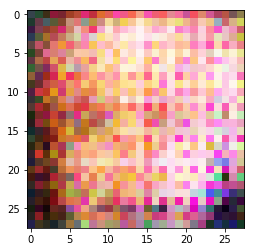

Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.7606


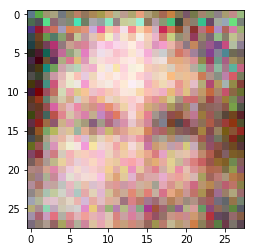

Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.8137


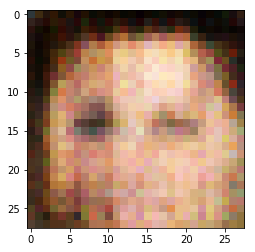

Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.8061


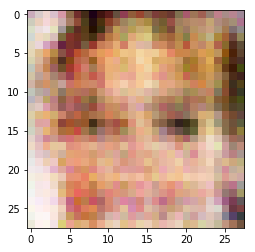

Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.7987


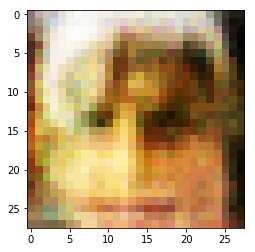

Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.8291


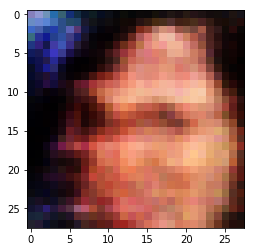

Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.7987


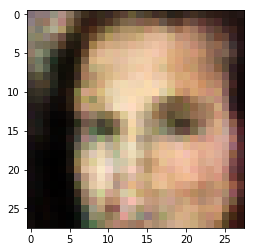

Epoch 1/2... Discriminator Loss: 1.2472... Generator Loss: 0.8223


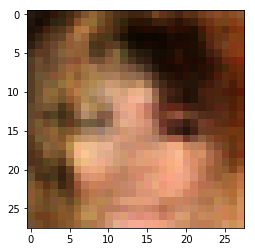

Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.8216


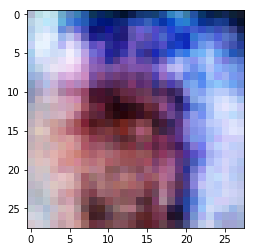

Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.9053


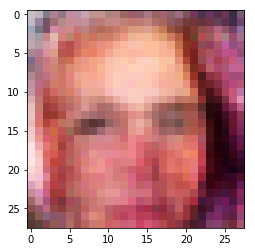

Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 0.8181


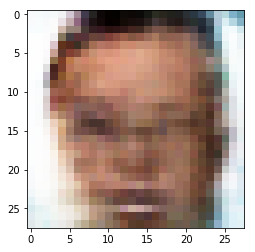

Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.8011


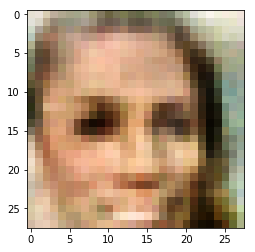

Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.7686


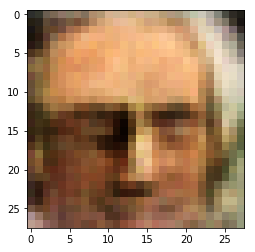

Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.7817


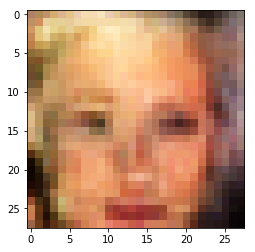

Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.7851


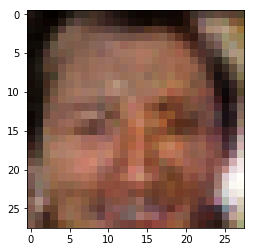

Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.7491


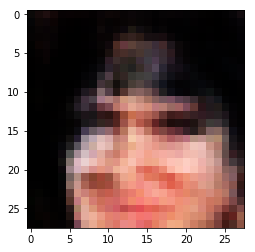

Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.8248


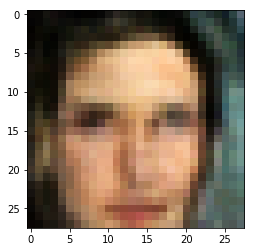

Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.8288


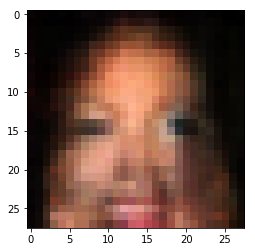

Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.9028


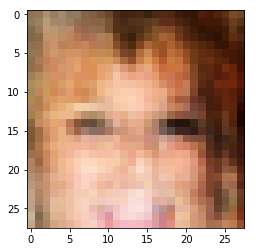

Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.8649


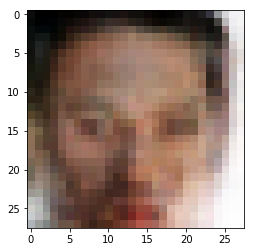

Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.5877


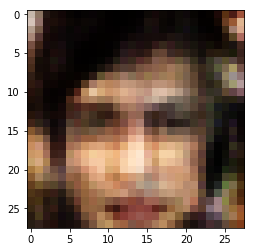

Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.8399


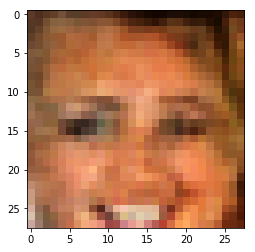

Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.9666


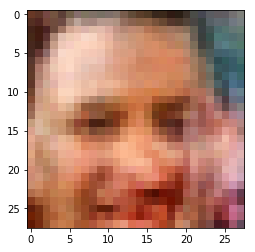

Epoch 1/2... Discriminator Loss: 1.6096... Generator Loss: 0.5922


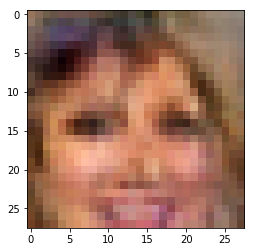

Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.8644


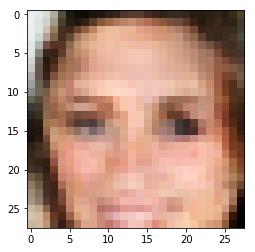

Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.8394


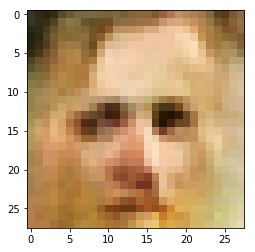

Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.8150


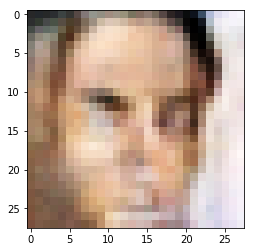

Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.8076


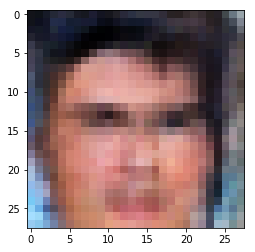

Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.7341


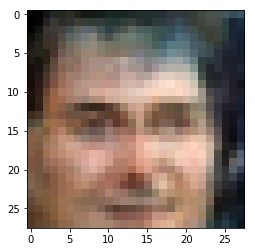

Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.8216


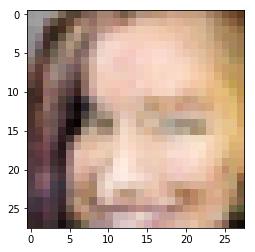

Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.7909


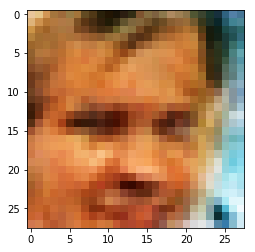

Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.7755


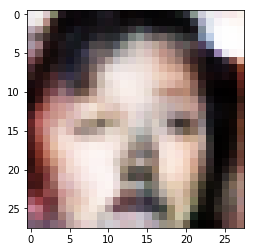

Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.8359


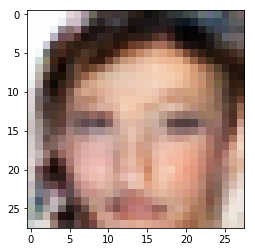

Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.8226


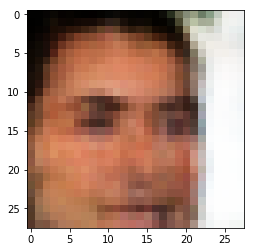

Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.8345


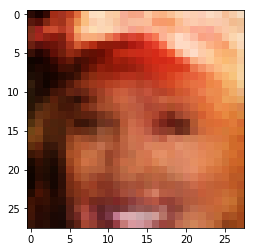

Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.8017


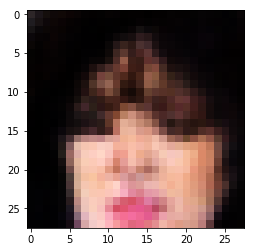

Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.8775


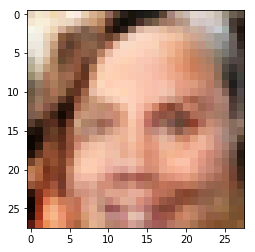

Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.8343


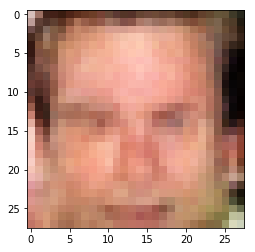

Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 0.8590


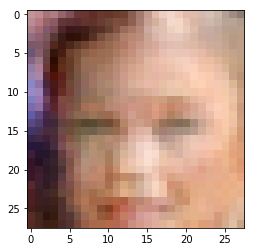

Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7886


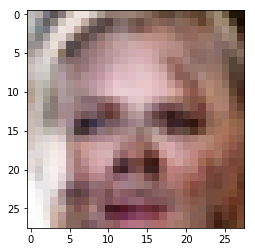

Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.8902


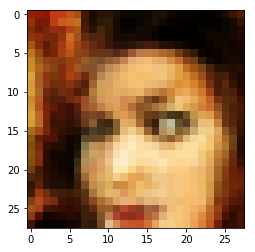

Epoch 2/2... Discriminator Loss: 1.5720... Generator Loss: 0.5963


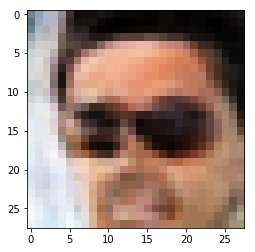

Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.8961


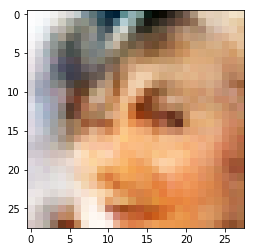

Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 0.8322


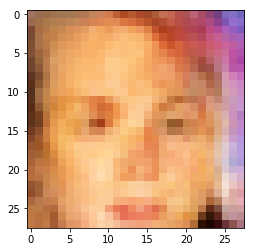

Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.8321


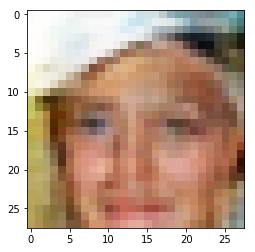

Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.7877


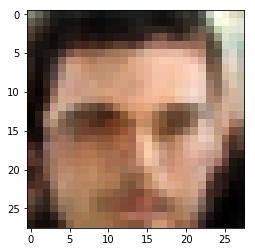

Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7361


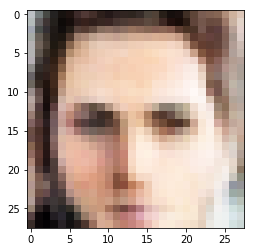

Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.7990


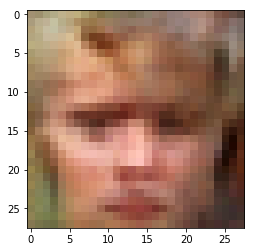

Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.8644


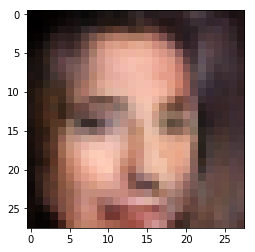

Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.8009


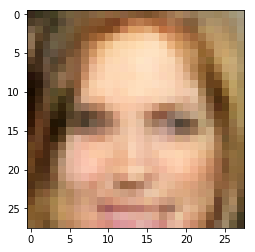

Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.8167


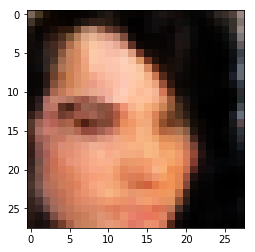

Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 0.9522


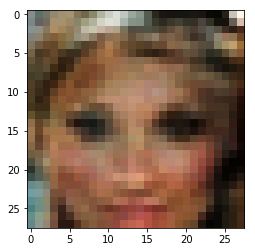

Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.8831


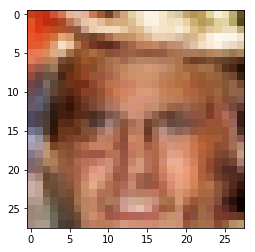

Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 0.9832


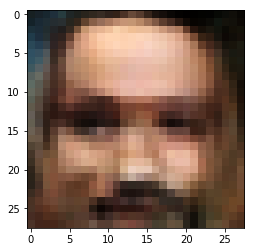

Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.8647


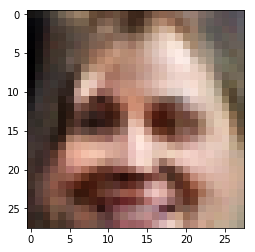

Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.7872


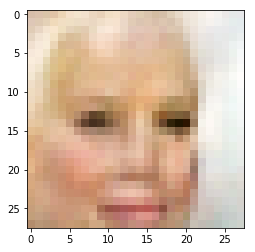

Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.9602


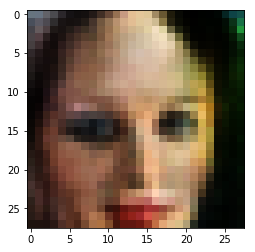

Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.9075


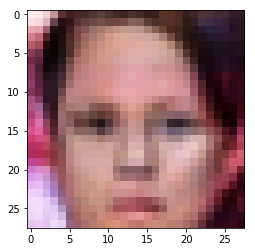

Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.8984


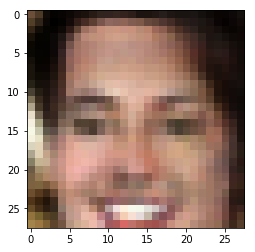

Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.6280


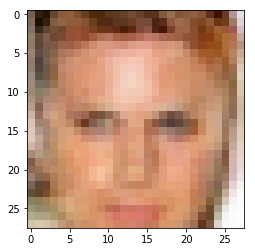

Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.9766


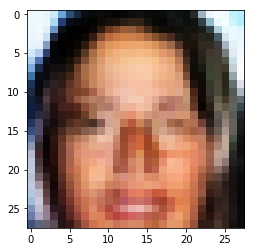

Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 0.8852


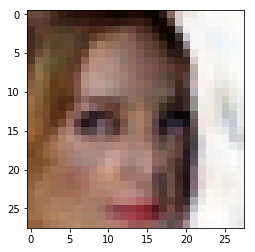

Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.8455


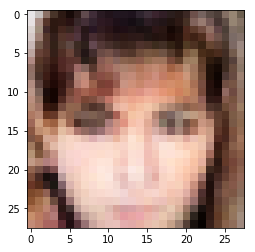

In [29]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

## Conclusion

Congratulations! You know now what GANs do and even know how to generate images of human faces using them. You might ask: “What do I need this for? I will never have to generate images of random faces.” While that might be true, GANs have many other applications.

Researchers at the University of Michigan and the Max Planck Institute in Germany used GANs to generate images from text. They were able to generate extremely real looking flowers and birds based on written descriptions. This could be extended to something very useful, like police sketches or graphic design.

Researchers at Berkeley also managed to create a GAN that enhances blurry images and even reconstructs corrupted image data.

GANs are extremely powerful and who knows—maybe you will invent their next groundbreaking application.

This post is a collaboration between O'Reilly and TensorFlow. See our statement of editorial independence.

### Dominic Monn

Dominic Monn is currently a deep learning intern at NVIDIA in Zurich, Switzerland. He started his career in Software Engineering as a 15-year old as part of a 4-year apprenticeship program, prior to joining NVIDIA. Right now, he is researching multiple ways to apply reinforcement learning in gaming.

Dominic is excited about applied deep learning and education. He has demonstrated that by graduating from multiple AI-related Nanodegrees and becoming a mentor at Udacity. If he’s not at work, you might find Dominic absorbed by a video game, a series, or a coding project.